<a href="https://colab.research.google.com/github/lucevito/image/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive


Mounted at /content/drive/
/content/drive/MyDrive


In [ ]:
import torch
import os

# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate
#Learning rate controls how quickly or slowly a neural network model learns a problem
INIT_LR = 0.001

#One epoch leads to underfitting of the curve in the graph
NUM_EPOCHS = 40

#The batch size defines the number of samples that will be propagated through the network.
BATCH_SIZE = 64

# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions(soglia)
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])



In [ ]:
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	# return the number of total samples contained in the dataset
	def __len__(self):
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
	
		# check to see if we are applying any transformations
		if self.transforms is not None:

			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)
	
    

In [ ]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
	
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs
	
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
	
    
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
	
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
	
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
        
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
	
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [ ]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)

testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())


# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0


	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
	
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	 
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
 
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))



[INFO] saving testing image paths...
[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...
[INFO] training the network...


  2%|▎         | 1/40 [05:27<3:32:47, 327.38s/it]

[INFO] EPOCH: 1/40
Train loss: 0.589681, Test loss: 0.6020


  5%|▌         | 2/40 [05:45<1:31:57, 145.19s/it]

[INFO] EPOCH: 2/40
Train loss: 0.563196, Test loss: 0.5941


  8%|▊         | 3/40 [06:03<53:55, 87.44s/it]   

[INFO] EPOCH: 3/40
Train loss: 0.551425, Test loss: 0.5599


 10%|█         | 4/40 [06:21<35:52, 59.79s/it]

[INFO] EPOCH: 4/40
Train loss: 0.504999, Test loss: 0.5573


 12%|█▎        | 5/40 [06:38<25:57, 44.50s/it]

[INFO] EPOCH: 5/40
Train loss: 0.437995, Test loss: 0.4551


 15%|█▌        | 6/40 [06:56<20:09, 35.57s/it]

[INFO] EPOCH: 6/40
Train loss: 0.426851, Test loss: 0.4303


 18%|█▊        | 7/40 [07:15<16:26, 29.90s/it]

[INFO] EPOCH: 7/40
Train loss: 0.404631, Test loss: 0.3983


 20%|██        | 8/40 [07:32<13:50, 25.95s/it]

[INFO] EPOCH: 8/40
Train loss: 0.393204, Test loss: 0.4059


 22%|██▎       | 9/40 [07:50<12:04, 23.38s/it]

[INFO] EPOCH: 9/40
Train loss: 0.412154, Test loss: 0.4159


 25%|██▌       | 10/40 [08:08<10:56, 21.89s/it]

[INFO] EPOCH: 10/40
Train loss: 0.374620, Test loss: 0.3792


 28%|██▊       | 11/40 [08:26<09:55, 20.53s/it]

[INFO] EPOCH: 11/40
Train loss: 0.376493, Test loss: 0.3833


 30%|███       | 12/40 [08:47<09:45, 20.90s/it]

[INFO] EPOCH: 12/40
Train loss: 0.376634, Test loss: 0.3869


 32%|███▎      | 13/40 [09:06<09:01, 20.04s/it]

[INFO] EPOCH: 13/40
Train loss: 0.362826, Test loss: 0.3636


 35%|███▌      | 14/40 [09:23<08:23, 19.38s/it]

[INFO] EPOCH: 14/40
Train loss: 0.368147, Test loss: 0.3731


 38%|███▊      | 15/40 [09:41<07:52, 18.90s/it]

[INFO] EPOCH: 15/40
Train loss: 0.360448, Test loss: 0.4019


 40%|████      | 16/40 [10:00<07:33, 18.90s/it]

[INFO] EPOCH: 16/40
Train loss: 0.370561, Test loss: 0.3790


 42%|████▎     | 17/40 [10:18<07:07, 18.59s/it]

[INFO] EPOCH: 17/40
Train loss: 0.354719, Test loss: 0.3850


 45%|████▌     | 18/40 [10:36<06:42, 18.31s/it]

[INFO] EPOCH: 18/40
Train loss: 0.351342, Test loss: 0.3659


 48%|████▊     | 19/40 [10:54<06:26, 18.41s/it]

[INFO] EPOCH: 19/40
Train loss: 0.349606, Test loss: 0.3489


 50%|█████     | 20/40 [11:12<06:05, 18.27s/it]

[INFO] EPOCH: 20/40
Train loss: 0.345535, Test loss: 0.3698


 52%|█████▎    | 21/40 [11:30<05:43, 18.06s/it]

[INFO] EPOCH: 21/40
Train loss: 0.343105, Test loss: 0.3422


 55%|█████▌    | 22/40 [11:48<05:28, 18.26s/it]

[INFO] EPOCH: 22/40
Train loss: 0.344466, Test loss: 0.3734


 57%|█████▊    | 23/40 [12:06<05:07, 18.10s/it]

[INFO] EPOCH: 23/40
Train loss: 0.347975, Test loss: 0.3375


 60%|██████    | 24/40 [12:24<04:47, 17.97s/it]

[INFO] EPOCH: 24/40
Train loss: 0.333522, Test loss: 0.3352


 62%|██████▎   | 25/40 [12:43<04:34, 18.32s/it]

[INFO] EPOCH: 25/40
Train loss: 0.467802, Test loss: 0.4353


 65%|██████▌   | 26/40 [13:01<04:15, 18.22s/it]

[INFO] EPOCH: 26/40
Train loss: 0.412387, Test loss: 0.4010


 68%|██████▊   | 27/40 [13:19<03:55, 18.12s/it]

[INFO] EPOCH: 27/40
Train loss: 0.379165, Test loss: 0.3862


 70%|███████   | 28/40 [13:37<03:36, 18.05s/it]

[INFO] EPOCH: 28/40
Train loss: 0.370670, Test loss: 0.3783


 72%|███████▎  | 29/40 [13:55<03:19, 18.17s/it]

[INFO] EPOCH: 29/40
Train loss: 0.359778, Test loss: 0.4138


 75%|███████▌  | 30/40 [14:13<03:00, 18.07s/it]

[INFO] EPOCH: 30/40
Train loss: 0.361648, Test loss: 0.3831


 78%|███████▊  | 31/40 [14:31<02:42, 18.03s/it]

[INFO] EPOCH: 31/40
Train loss: 0.432824, Test loss: 0.3837


 80%|████████  | 32/40 [14:49<02:24, 18.12s/it]

[INFO] EPOCH: 32/40
Train loss: 0.384753, Test loss: 0.3742


 82%|████████▎ | 33/40 [15:07<02:06, 18.00s/it]

[INFO] EPOCH: 33/40
Train loss: 0.357784, Test loss: 0.3750


 85%|████████▌ | 34/40 [15:25<01:47, 17.92s/it]

[INFO] EPOCH: 34/40
Train loss: 0.348817, Test loss: 0.3656


 88%|████████▊ | 35/40 [15:44<01:31, 18.20s/it]

[INFO] EPOCH: 35/40
Train loss: 0.345353, Test loss: 0.3563


 90%|█████████ | 36/40 [16:01<01:12, 18.06s/it]

[INFO] EPOCH: 36/40
Train loss: 0.344678, Test loss: 0.3846


 92%|█████████▎| 37/40 [16:19<00:53, 17.98s/it]

[INFO] EPOCH: 37/40
Train loss: 0.344617, Test loss: 0.3638


 95%|█████████▌| 38/40 [16:37<00:36, 18.00s/it]

[INFO] EPOCH: 38/40
Train loss: 0.340518, Test loss: 0.3495


 98%|█████████▊| 39/40 [16:55<00:17, 17.94s/it]

[INFO] EPOCH: 39/40
Train loss: 0.344089, Test loss: 0.3602


100%|██████████| 40/40 [17:13<00:00, 25.83s/it]

[INFO] EPOCH: 40/40
Train loss: 0.333193, Test loss: 0.3527
[INFO] total time taken to train the model: 1033.27s


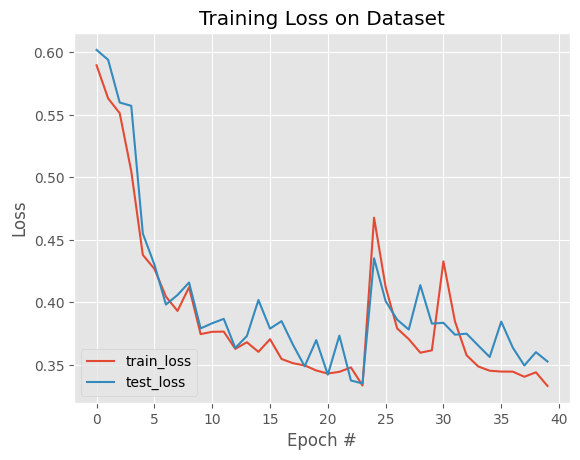

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)




[INFO] loading up test image paths...
[INFO] load up model...


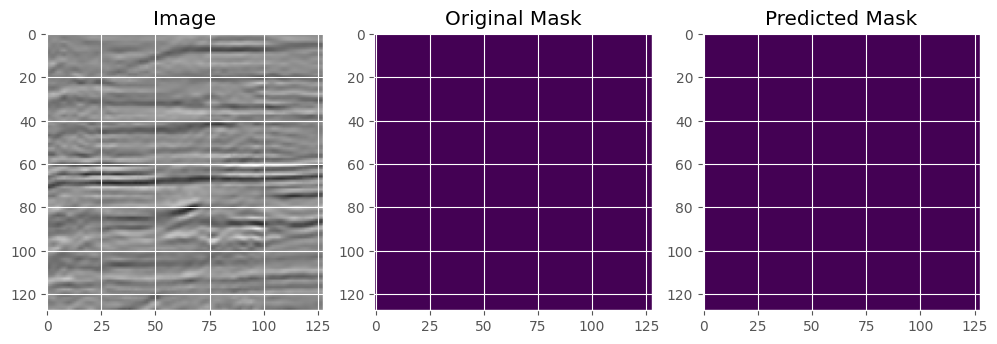

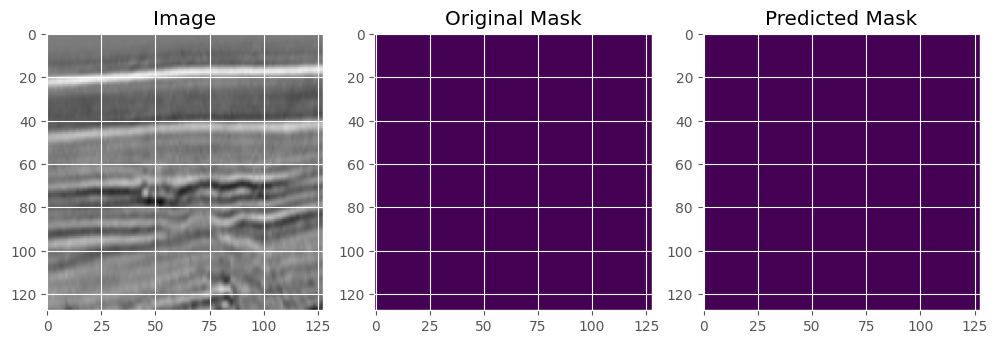

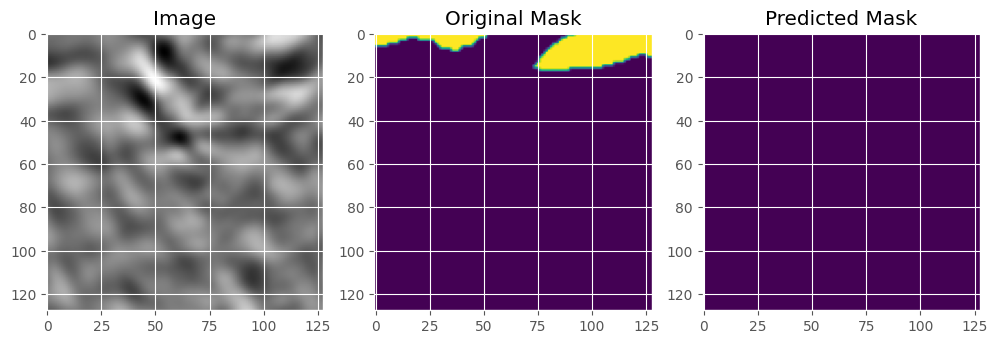

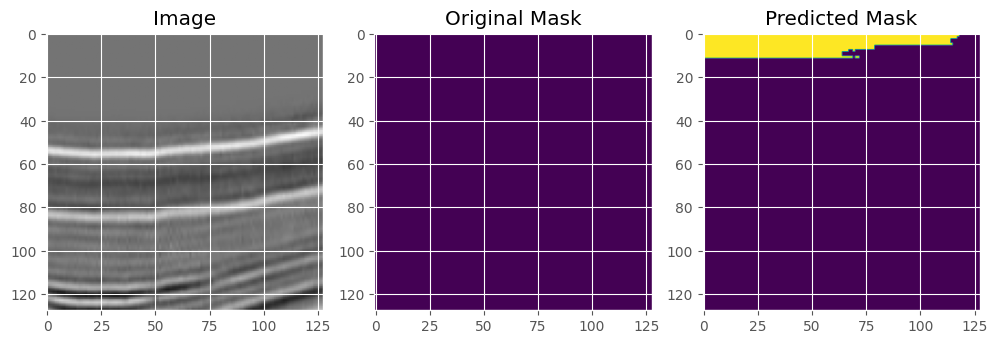

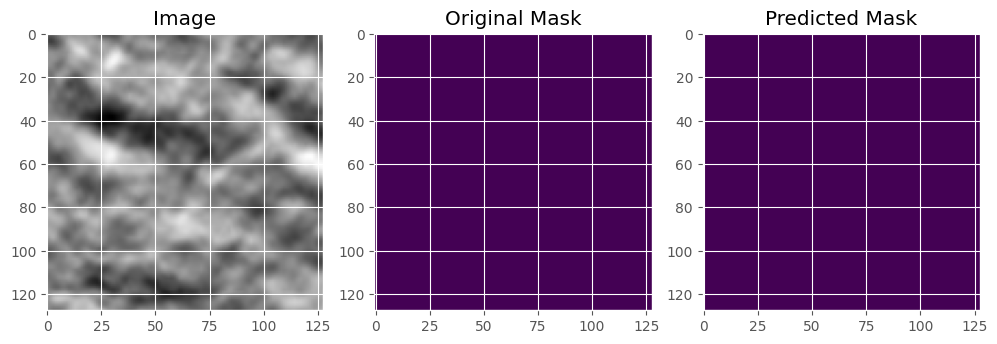

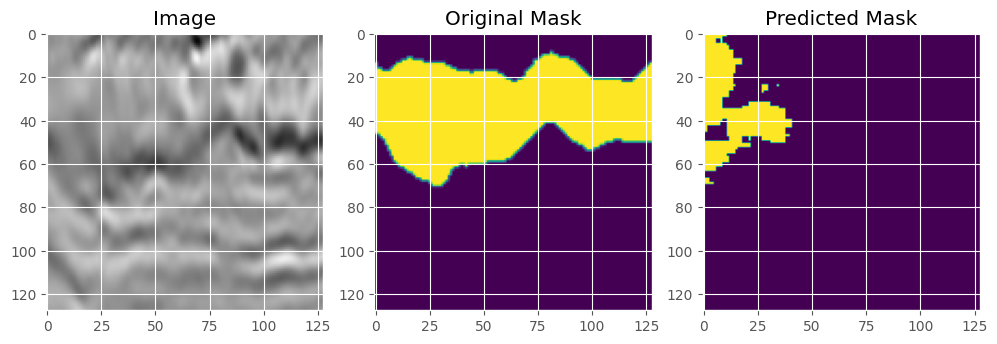

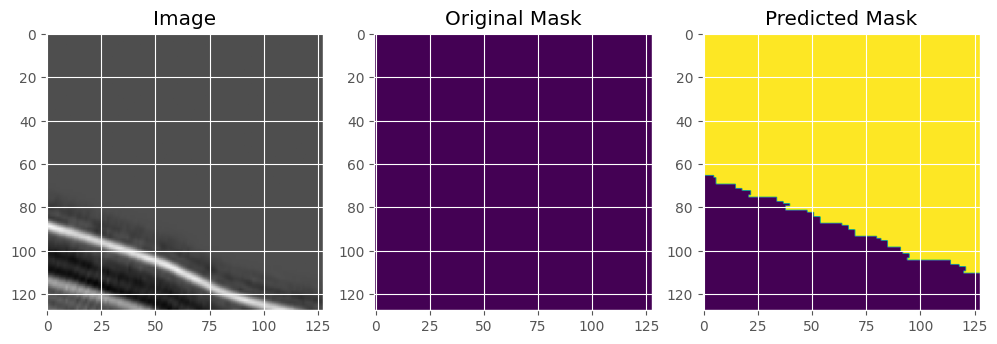

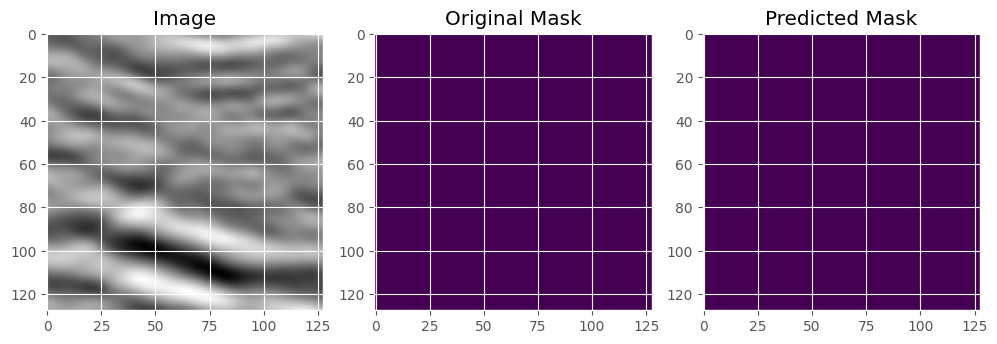

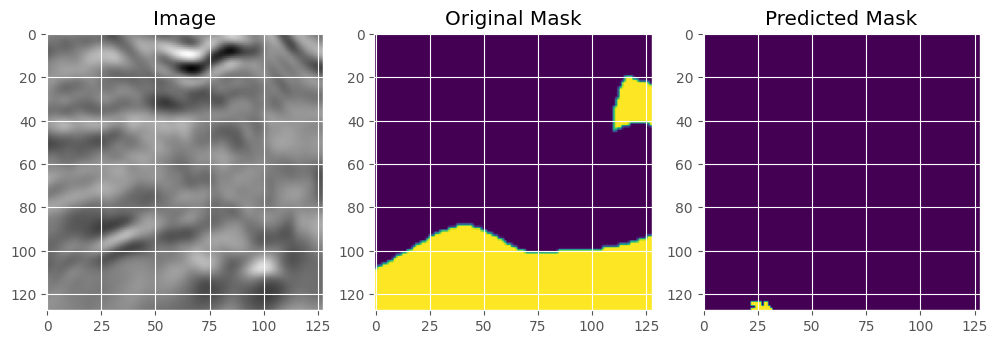

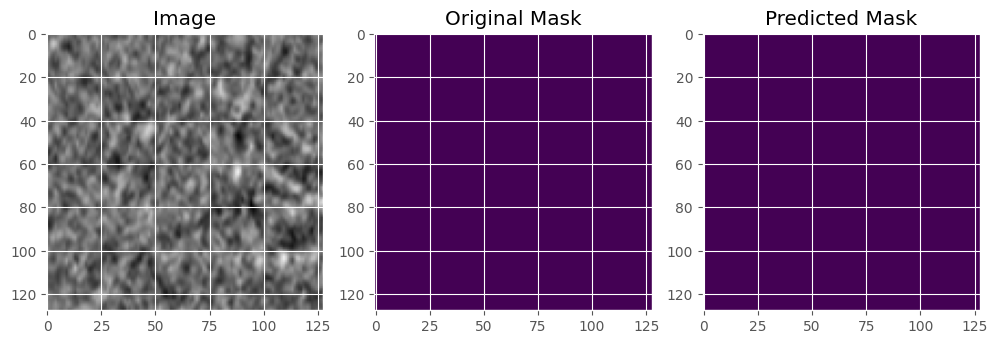

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
	
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
			INPUT_IMAGE_HEIGHT))
		
        		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)
		


# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)
	
